# Advanced Lane Finding Project

The goals / steps of this project are the following:
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Process image to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image and output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
8. Video Processing Pipeline

In [1]:
#importing packages

import numpy as np
import cv2
import glob
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

from scipy import signal
import scipy
import re
import pickle as pickle
from collections import deque
import imageio

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline



# 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

At first we are going to correct images that are distorted by camera. To to this we use samples of chessboard patterns recorded with the same camera that was also used for images and video recordings provided.

At the begining we preparr "object points" with (x, y) coordinates of the chessboard corners in the world. Objpoints are appended with a copy of it every time program successfully detect all chessboard corners. Imgpoints are appended with the  position of each of the corners in the image plane on successful chessboard detection.

We use objpoints and imgpoints to compute the camera calibration and distortion coefficients by cv2.calibrateCamera() function. To undistort we apply distortion correction by the cv2.undistort() function.

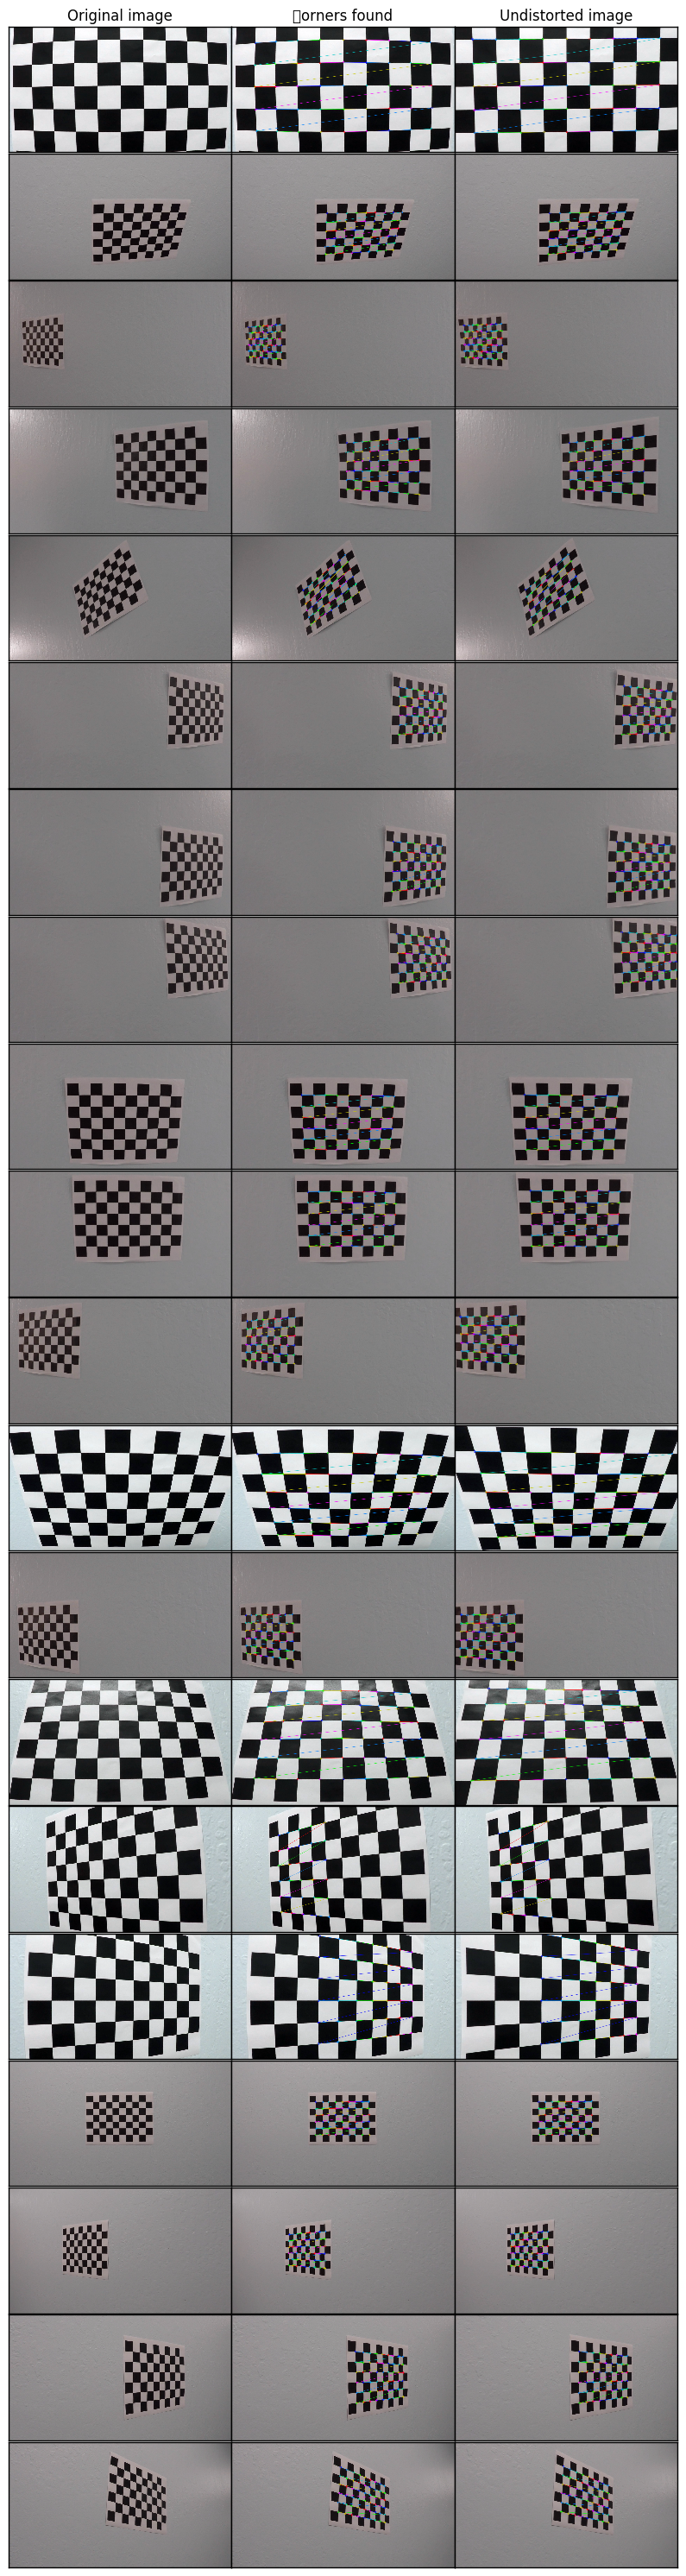

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

# The images of checker board may have different dimensions.
# We check the following dimension combinations:

#(9,6)
objp1 = np.zeros((6*9,3), np.float32)
objp1[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
# (9,5)
objp2 = np.zeros((5*9,3), np.float32)
objp2[:,:2] = np.mgrid[0:9, 0:5].T.reshape(-1,2)
#(8,6)
objp3 = np.zeros((6*8,3), np.float32)
objp3[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)
# (9,4)
objp4 = np.zeros((4*9,3), np.float32)
objp4[:,:2] = np.mgrid[0:9, 0:4].T.reshape(-1,2)
# (7,6)
objp5 = np.zeros((6*7,3), np.float32)
objp5[:,:2] = np.mgrid[0:7, 0:6].T.reshape(-1,2)
# (5,6)
objp6 = np.zeros((6*5,3), np.float32)
objp6[:,:2] = np.mgrid[0:5, 0:6].T.reshape(-1,2)
# (4, 5)
objp7 = np.zeros((5*4,3), np.float32)
objp7[:,:2] = np.mgrid[0:4, 0:5].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Load a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Configure plot
fig = plt.figure(figsize=(10, len(images)*1.9))
w_ratios = [1 for n in range(3)]
h_ratios = [1 for n in range(len(images))]
grid = gridspec.GridSpec(len(images), 3, wspace=0.0, hspace=0.0, width_ratios=w_ratios, height_ratios=h_ratios)
i = 0

# Search for chessboard corners in loaded images list
for id, filename in enumerate(images):
    img = cv2.imread(filename)
    img2 = np.copy(img)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners using possible combinations of dimensions.
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    objp = objp1
    if not ret:
        ret, corners = cv2.findChessboardCorners(gray, (9,5), None)
        objp = objp2
    if not ret:
        ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
        objp = objp3
    if not ret:
        ret, corners = cv2.findChessboardCorners(gray, (9,4), None)
        objp = objp4
    if not ret:
        ret, corners = cv2.findChessboardCorners(gray, (7,6), None)
        objp = objp5
    if not ret:
        ret, corners = cv2.findChessboardCorners(gray, (5,6), None)
        objp = objp6
    if not ret:
        ret, corners = cv2.findChessboardCorners(gray, (5,6), None)
        objp = objp7
    # print("corners: ", corners.shape, "\n", corners)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img2, (corners.shape[1],corners.shape[0]), corners, ret)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        img3 = cv2.undistort(img2, mtx, dist, None, mtx)

        # next image
        ax = plt.Subplot(fig, grid[i])
        ax.imshow(img)
        if i==0:
            ax.set_title('Original image')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        i += 1
        ax = plt.Subplot(fig, grid[i])
        ax.imshow(img2)
        if i==1:
            ax.set_title('Сorners found')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        i += 1
        ax = plt.Subplot(fig, grid[i])
        ax.imshow(img3)
        if i==2:
            ax.set_title('Undistorted image')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        i += 1

    else:
        # next image
        ax = plt.Subplot(fig, grid[i])
        ax.set_title('Corners are not found in %s'%(filename))
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        i += 3
plt.show()

Save correction coeficients for further use in file camera_distortion_pickle.p

In [3]:
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_distortion_pickle.p", "wb" ) )

In [4]:
out_dir='output_images/'

# load pickled distortion matrix
with open('camera_distortion_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

# 2. Apply a distortion correction to raw images.

In [5]:
# Visualize undistortion
# Step through the list and search for chessboard corners
# load pickled distortion matrix

with open('camera_distortion_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
# Visualize undistortion on test images

for id, filename in enumerate(images):
    img = cv2.imread(filename)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    image_name=os.path.split(filename)[1]
    write_name = out_dir+'undistorted_'+image_name
    cv2.imwrite(write_name,dst)
    print(write_name)
    cv2.imshow('dst', dst)
    cv2.waitKey(500)
cv2.destroyAllWindows()

output_images/undistorted_calibration1.jpg
output_images/undistorted_calibration10.jpg
output_images/undistorted_calibration11.jpg
output_images/undistorted_calibration12.jpg
output_images/undistorted_calibration13.jpg
output_images/undistorted_calibration14.jpg
output_images/undistorted_calibration15.jpg
output_images/undistorted_calibration16.jpg
output_images/undistorted_calibration17.jpg
output_images/undistorted_calibration18.jpg
output_images/undistorted_calibration19.jpg
output_images/undistorted_calibration2.jpg
output_images/undistorted_calibration20.jpg
output_images/undistorted_calibration3.jpg
output_images/undistorted_calibration4.jpg
output_images/undistorted_calibration5.jpg
output_images/undistorted_calibration6.jpg
output_images/undistorted_calibration7.jpg
output_images/undistorted_calibration8.jpg
output_images/undistorted_calibration9.jpg


In [6]:
images = glob.glob('test_images/*.jpg')
# Visualize undistortion on test images

for id, filename in enumerate(images):
    img = cv2.imread(filename)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    image_name=os.path.split(filename)[1]
    write_name = out_dir+'undistorted_'+image_name
    cv2.imwrite(write_name,dst)
    print(write_name)
    cv2.imshow('dst', dst)
    cv2.waitKey(500)
cv2.destroyAllWindows()

output_images/undistorted_straight_lines1.jpg
output_images/undistorted_straight_lines2.jpg
output_images/undistorted_test1.jpg
output_images/undistorted_test2.jpg
output_images/undistorted_test3.jpg
output_images/undistorted_test4.jpg
output_images/undistorted_test5.jpg
output_images/undistorted_test6.jpg


# 3. Process image to create a thresholded binary image.
For the best results in color thresholding we use HLS space. We apply sobel filters to detect edges. We choose only the L and S channel, because its most informative for lane finding and best performance in different color and lighting conditions. 
We use S-channel for a gradient filter along X and Saturation threshold
We use L-channel for a luminosity threshold filter.
Then we merge the results of these filters to binarize an image.

In [7]:
def undistort(img):
    result = cv2.undistort(img, mtx, dist, None, mtx)
    return result


# Binarize image
def binarize_image(img, s_thresh=(120, 255), sx_thresh=(20, 255),l_thresh=(40,255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    # sobelx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255))
    # l_channel_col=np.dstack((l_channel,l_channel, l_channel))
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    channels = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')        
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return  binary,channels


Examples of output binarized

Show binarize and channel processing examlpes of:
straight_lines1.jpg
straight_lines2.jpg
test1.jpg
test2.jpg
test3.jpg
test4.jpg
test5.jpg
test6.jpg


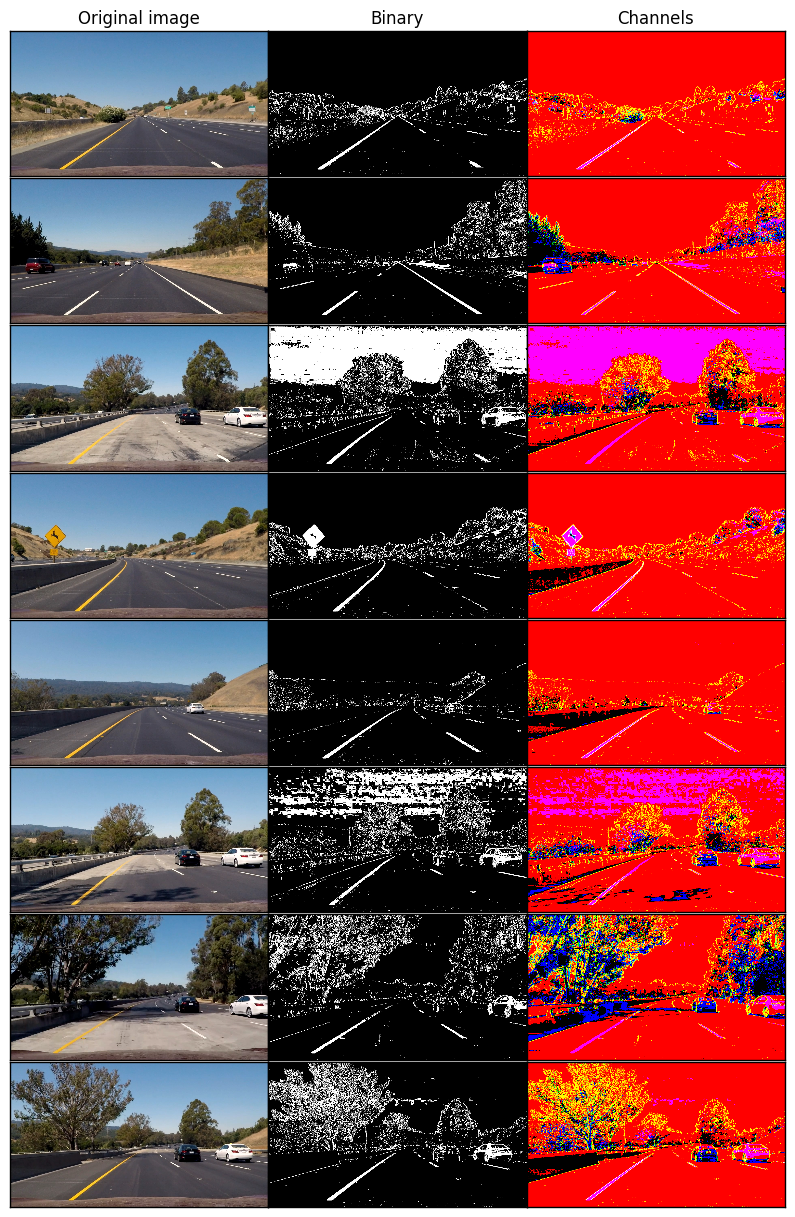

In [8]:
images = glob.glob('test_images/*.jpg')
print ('Show binarize and channel processing examlpes of:')
# Configure plot
fig = plt.figure(figsize=(10, len(images)*1.9))
w_ratios = [1 for n in range(3)]
h_ratios = [1 for n in range(len(images))]
grid = gridspec.GridSpec(len(images), 3, wspace=0.0, hspace=0.0, width_ratios=w_ratios, height_ratios=h_ratios)
i = 0

for id, filename in enumerate(images):
    img = mpimg.imread(filename)
    binary,channels = binarize_image(img)
    #plt.imsave(out_dir+'binary.jpg',binary)
    #plt.imsave(out_dir+'channels.jpg',channels)   
    
    image_name=os.path.split(filename)[1]
    print (image_name)
    write_name_binary = out_dir+'binary_'+image_name
    write_name_channels = out_dir+'channels_'+image_name
    #write_name = out_dir+'undistorted_'+image_name
    cv2.imwrite(write_name_binary,binary)
    cv2.imwrite(write_name_channels,channels)
    #print(write_name)
    #cv2.imshow('dst', dst)
    #cv2.waitKey(500)
    
    # next image
    ax = plt.Subplot(fig, grid[i])
    ax.imshow(img)
    if i==0:
        ax.set_title('Original image')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)
    i += 1
    ax = plt.Subplot(fig, grid[i])
    ax.imshow(binary)
    if i==1:
        ax.set_title('Binary')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)
    i += 1
    ax = plt.Subplot(fig, grid[i])
    ax.imshow(channels)
    if i==2:
        ax.set_title('Channels')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)
    i += 1


plt.show()

# 4. Apply a perspective transform to rectify binary image ("birds-eye view").
For perspective transform to "bird's eye" perspective we use function called warp() and we use unwarp() fucntion for reverse transformation. In function we use the parameters src and  dst to  transform images.

For correct transformation we provide four source and destination points. I have selected the following source and destination points.

** Source points:**
190, 720	
588, 456	
698, 456	
1145,720	

**Destination points:**
340, 720
340, 0
995, 0
995, 720


In [9]:
def warp(img):
    corners = np.float32([[190,720],[588,456],[698,456],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    

    M = cv2.getPerspectiveTransform(src, dst)

    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M

In [10]:
def unwarp(img):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    M = cv2.getPerspectiveTransform(dst,src)
    unwarped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return unwarped, M

I verified the performance of my perspective transformation by transforming an image with straight lines (./test_images/straight_lines1.jpg) using above source and destination points. The result is below.

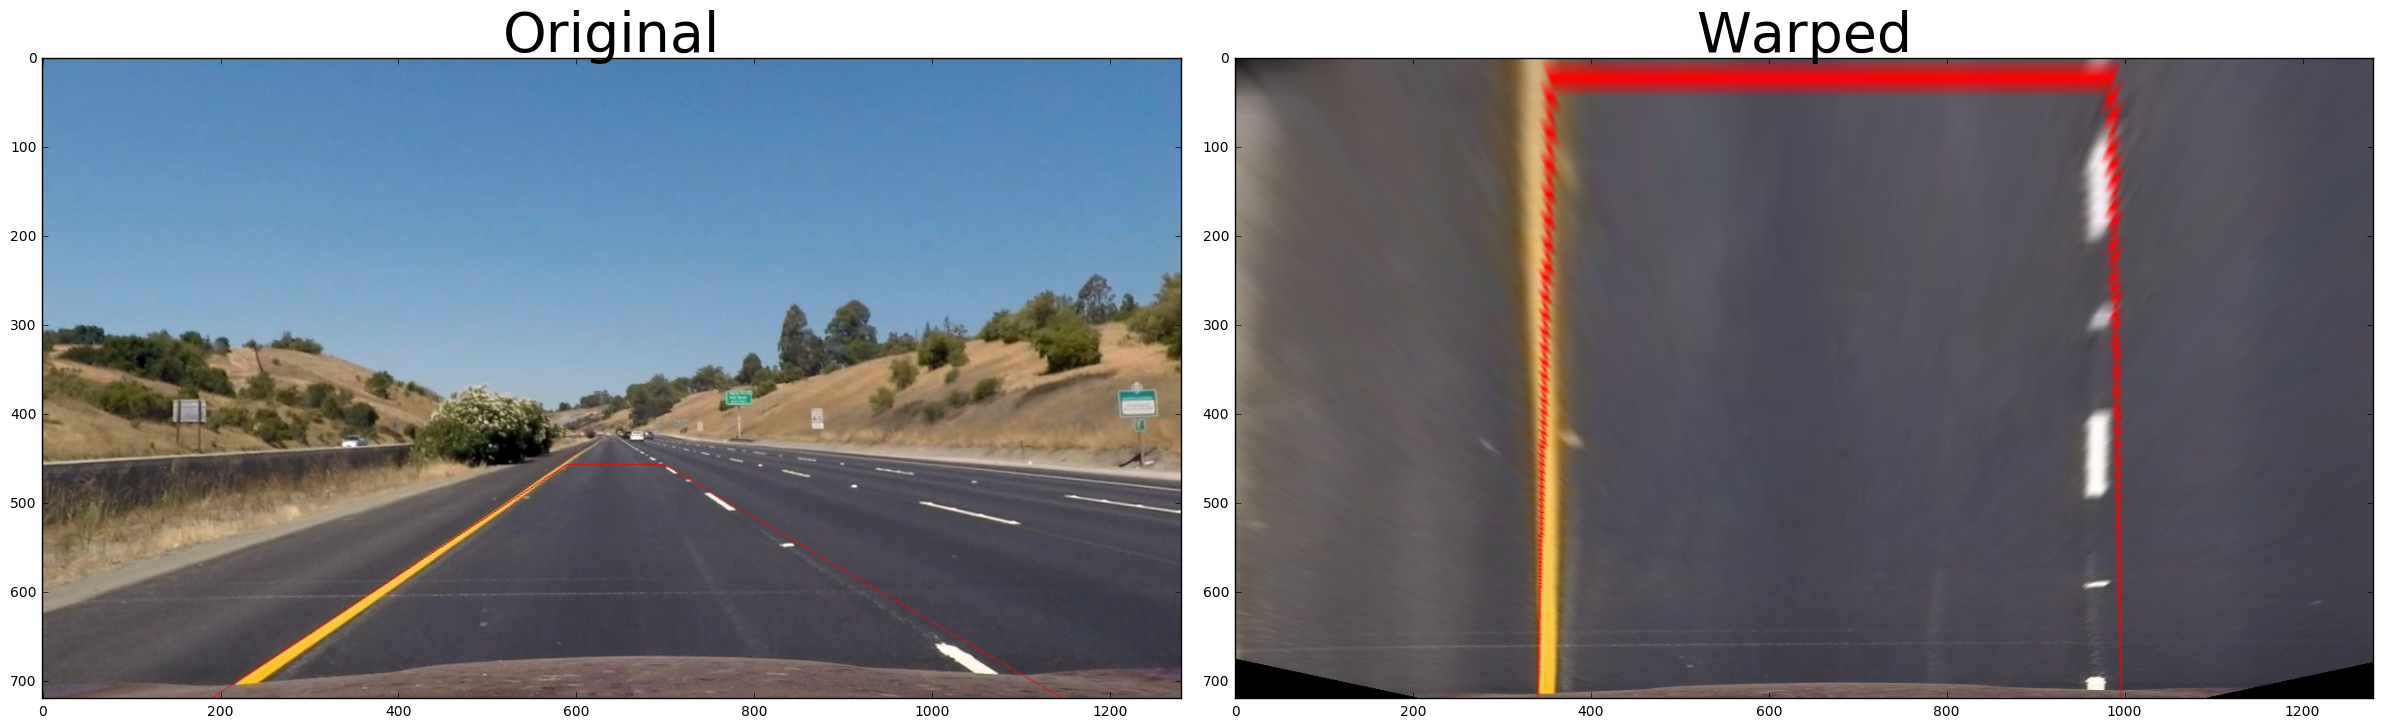

In [11]:
img=plt.imread('./test_images/straight_lines1.jpg')
corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
img = cv2.undistort(img, mtx, dist, None, mtx)
imshape = img.shape

corner_tuples=[]
for ind,c in enumerate(corners):
    corner_tuples.append(tuple(corners[ind]))

cv2.line(img, corner_tuples[0], corner_tuples[1], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[1], corner_tuples[2], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[2], corner_tuples[3], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[3], corner_tuples[0], color=[255,0,0], thickness=1)

warped,_ = warp(img) 
plt.imsave(out_dir+'straight_red.jpg',img)
plt.imsave(out_dir+'straight_red_warped.jpg',warped)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Warped', fontsize=40)

I also included a region of interest to reduce artefacts at the bottom of the image - the function region_of_interest(). See the samples below.

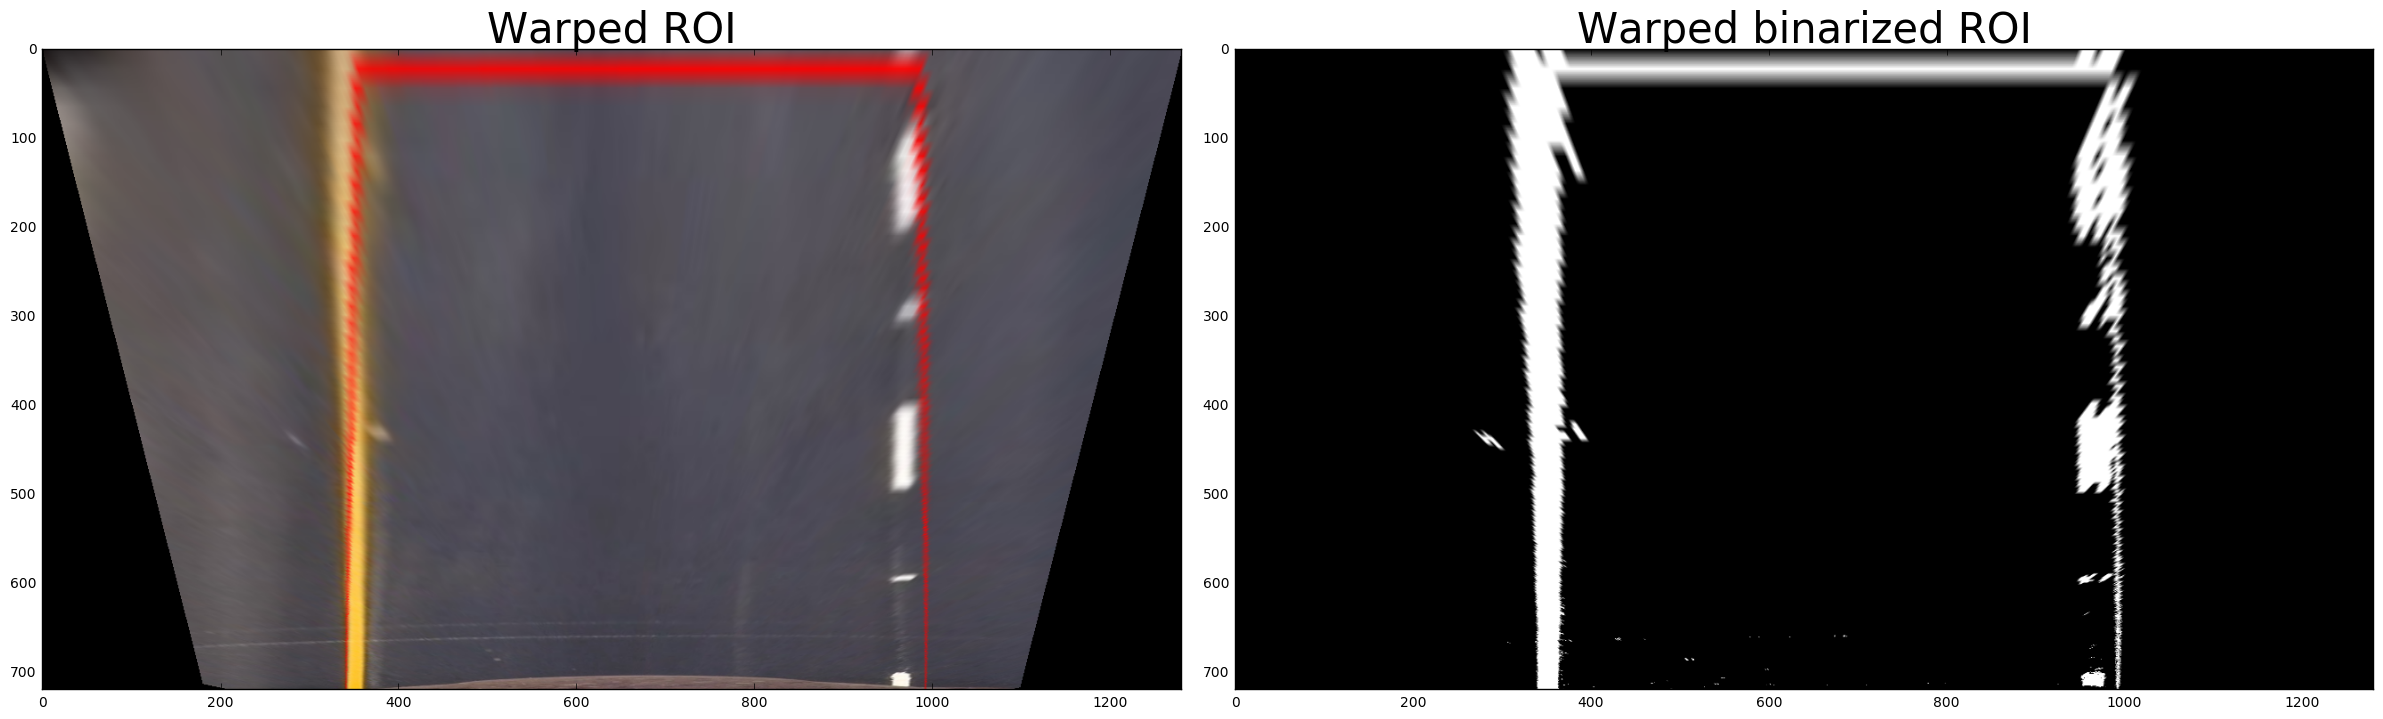

In [12]:
def region_of_interest(img):
    # Applies an image mask.

    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def warp_pipeline(img):
    undist = undistort(img)    
    result,_ = warp(undist)
    result = region_of_interest(result)
    return result
    
def warp_binarize_pipeline(img):
    undist = undistort(img)
    binary,_  = binarize_image(undist)
    result,_  = warp(binary)
    result = region_of_interest(result)
    return result 

warp_roi = warp_pipeline(img)
warp_binary_roi = warp_binarize_pipeline(img)

plt.imsave(out_dir+'warp_roi.jpg',warp_roi)
plt.imsave(out_dir+'warp_binary_roi.jpg',warp_binary_roi)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warp_roi)
ax1.set_title('Warped ROI', fontsize=30)

ax2.imshow(warp_binary_roi)
ax2.set_title('Warped binarized ROI', fontsize=30)

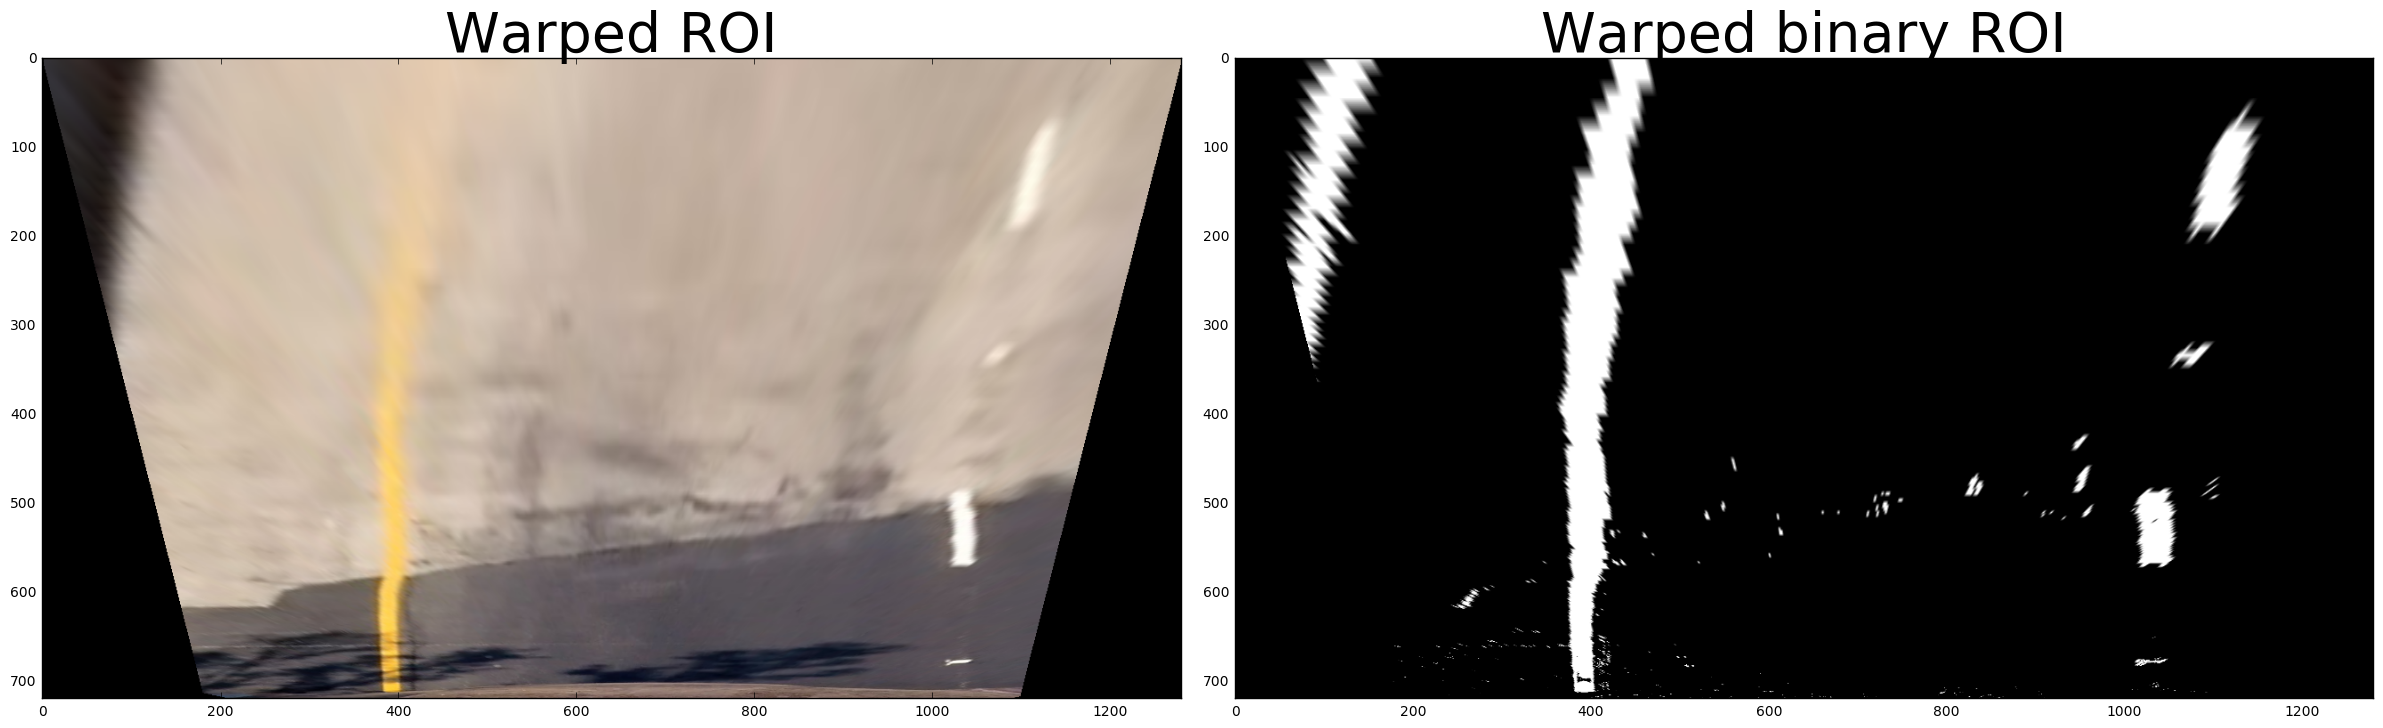

In [13]:
# Sample test image
img=plt.imread('test_images/test4.jpg')
warped = warp_pipeline(img)
warped_binary = warp_binarize_pipeline(img)

plt.imsave(out_dir+'warp_test4.jpg',warped)
plt.imsave(out_dir+'warp_binary_test4.jpg',warped_binary)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped)
ax1.set_title('Warped ROI', fontsize=40)

ax2.imshow(warped_binary)
ax2.set_title('Warped binary ROI', fontsize=40)

# 5. Detect lane pixels and fit to find the lane boundary.
I use the function find_peaks(img,thresh) to compute a histogram of detected pixel values. It takes the bottom half of a binarized and warped lane image. The function find_peaks returns the x values of the peaks that are larger than thresh.

The function get_next_slice(img,center_point,width) takes binary image and computes the average x value center of all detected pixels in a window centered at center_point of width. Then function returns a masked copy of img and a center.

The following function lane_from_window(binary,center_point,width) slices a binary image horizontally into 6 zones and applies get_next_window to each of slice. The center_point of each zone is the center value of the previous slice. Thus subsequent windows follow the lane if the road changes its curvature. The  lane_from_window returns a masked image of a single lane line. 

The Line.update(img) method takes a binary input image of a lane line candidate and fits a second order polynomial to the provided data. It also computes  metrics. Then I check chosen lanes and push them into que. Every time we find a new line, we update metrics. If we detect no lines, we use last result until the queue is empty and peaks need to be searched anew.

Then we save a fit to the lane candidate to current_fit_xvals attribute and its coefficients. Thus we get result of two lines.

In [14]:
def find_peaks(img,thresh):
    img_half=img[int(img.shape[0]/2):,:,0]
    data = np.sum(img_half, axis=0)
    filtered = scipy.ndimage.filters.gaussian_filter1d(data,20)
    xs = np.arange(len(filtered))
    peak_ind = signal.find_peaks_cwt(filtered, np.arange(20,300))
    peaks = np.array(peak_ind)
    peaks = peaks[filtered[peak_ind]>thresh]
    return peaks,filtered


def get_next_slice(img,center_point,width):
    
    ny,nx,_ = img.shape
    mask  = np.zeros_like(img)
    if (center_point <= width/2): center_point = width/2
    if (center_point >= nx-width/2): center_point = nx-width/2
    
    left  = center_point - width/2
    right = center_point + width/2
    
    vertices = np.array([[(left,0),(left,ny), (right,ny),(right,0)]], dtype=np.int32)
    ignore_mask_color=(255,255,255)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked = cv2.bitwise_and(mask,img)

    hist = np.sum(masked[:,:,0],axis=0)
    if max(hist>10000):
        center = np.argmax(hist)
    else:
        center = center_point
        
    return masked,center

def lane_from_window(binary,center_point,width):
    n_zones=6
    ny,nx,nc = binary.shape
    zones = binary.reshape(n_zones,-1,nx,nc)
    zones = zones[::-1] # start from the bottom slice
    window,center = get_next_slice(zones[0],center_point,width)
    
    for zone in zones[1:]:
        next_window,center = get_next_slice(zone,center,width)
        window = np.vstack((next_window,window))
    
    return window

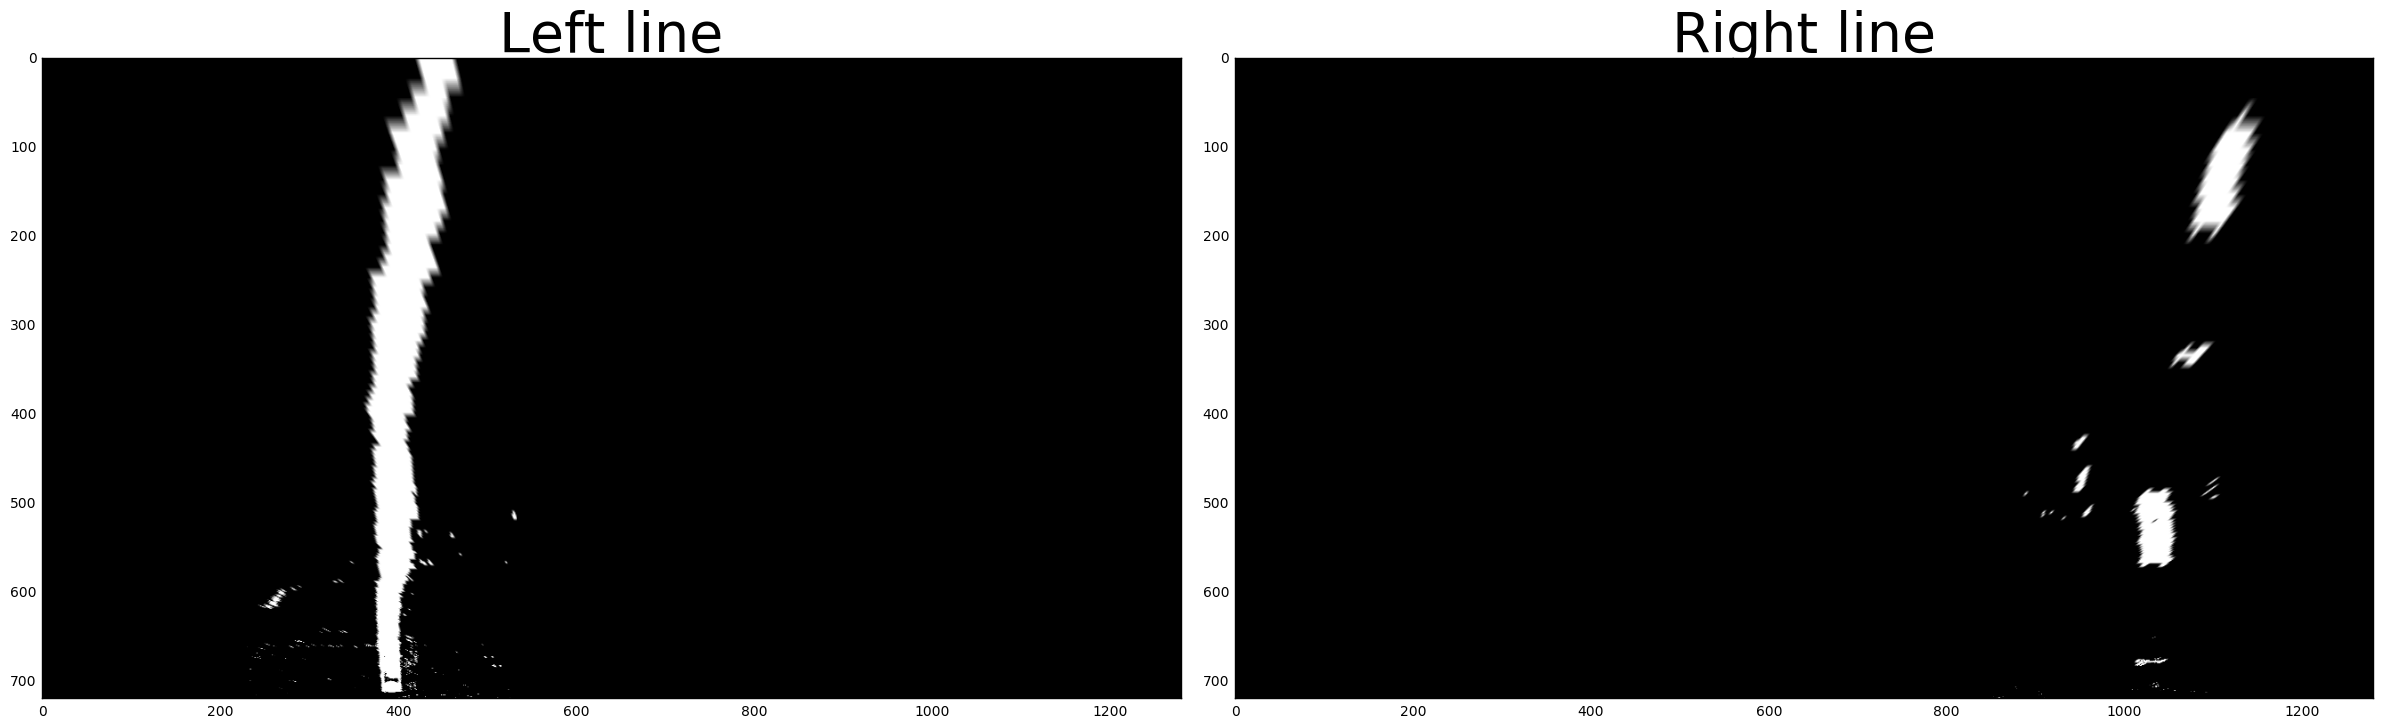

In [15]:
left_binary = lane_from_window(warped_binary,380,300)
right_binary = lane_from_window(warped_binary,1000,300)

plt.imsave(out_dir+'left_line.jpg',left_binary)
plt.imsave(out_dir+'right_line.jpg',right_binary)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(left_binary)
ax1.set_title('Left line', fontsize=40)

ax2.imshow(right_binary)
ax2.set_title('Right line', fontsize=40)

# 6. Determine the curvature of the lane and vehicle position with respect to center.
I compute the radius of curvature in method set_radius_of_curvature(). 
For a second order polynomial f(y)=A y^2 +B y + C the radius of curvature is given by R = [(1+(2 Ay +B)^2 )^3/2]/|2A|.

I compute the distance from the center of the lane in the set_line_base_pos() method. It measures the distance to each lane and computes the position.

In [16]:
# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self,n=5):
        # length of queue to store data
        self.n = n
        #number of fits in buffer
        self.n_buffered = 0
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([],maxlen=n)
        #average x values of the fitted line over the last n iterations
        self.avgx = None
        # fit coeffs of the last n fits
        self.recent_fit_coeffs = deque([],maxlen=n)        
        #polynomial coefficients averaged over the last n iterations
        self.avg_fit_coeffs = None  
        # xvals of the most recent fit
        self.current_fit_xvals = [np.array([False])]  
        #polynomial coefficients for the most recent fit
        self.current_fit_coeffs = [np.array([False])]          
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #y values for line fit
        self.fit_yvals = np.linspace(0, 100, num=101)*7.2  # always the same y-range as image
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # origin (pixels) of fitted line at the bottom of the image
        self.line_pos = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 

    def set_current_fit_xvals(self):
        yvals = self.fit_yvals
        self.current_fit_xvals = self.current_fit_coeffs[0]*yvals**2 + self.current_fit_coeffs[1]*yvals + self.current_fit_coeffs[2]
        
    def add_data(self):
        self.recent_xfitted.appendleft(self.current_fit_xvals)
        self.recent_fit_coeffs.appendleft(self.current_fit_coeffs)
        assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
        self.n_buffered = len(self.recent_xfitted)
        
    def pop_data(self):        
        if self.n_buffered>0:
            self.recent_xfitted.pop()
            self.recent_fit_coeffs.pop()
            assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
            self.n_buffered = len(self.recent_xfitted)
        
        return self.n_buffered
        
    def set_avgx(self):
        fits = self.recent_xfitted
        if len(fits)>0:
            avg=0
            for fit in fits:
                avg +=np.array(fit)
            avg = avg / len(fits)
            self.avgx = avg
            
    def set_avgcoeffs(self):
        coeffs = self.recent_fit_coeffs
        if len(coeffs)>0:
            avg=0
            for coeff in coeffs:
                avg +=np.array(coeff)
            avg = avg / len(coeffs)
            self.avg_fit_coeffs = avg
    
    def set_allxy(self,lane_candidate):
        self.ally,self.allx = (lane_candidate[:,:,0]>254).nonzero()

    def set_current_fit_coeffs(self):
        self.current_fit_coeffs = np.polyfit(self.ally, self.allx, 2)
    
    def get_diffs(self):
        if self.n_buffered>0:
            self.diffs = self.current_fit_coeffs - self.avg_fit_coeffs
        else:
            self.diffs = np.array([0,0,0], dtype='float')                 
            
    def set_radius_of_curvature(self):
        # Define y-value where we want radius of curvature (choose bottom of the image)
        y_eval = max(self.fit_yvals)
        if self.avg_fit_coeffs is not None:
            self.radius_of_curvature = ((1 + (2*self.avg_fit_coeffs[0]*y_eval + self.avg_fit_coeffs[1])**2)**1.5) \
                             /np.absolute(2*self.avg_fit_coeffs[0])
                        
            
    def set_line_base_pos(self):
        y_eval = max(self.fit_yvals)
        self.line_pos = self.current_fit_coeffs[0]*y_eval**2 \
                        +self.current_fit_coeffs[1]*y_eval \
                        + self.current_fit_coeffs[2]
        basepos = 640
        
        self.line_base_pos = (self.line_pos - basepos)*3.7/600.0 # 3.7 meters is about 600 pixels in the x direction

    # here come sanity checks of the computed metrics
    def accept_lane(self):
        flag = True
        maxdist = 2.8  # distance in meters from the lane
        if(abs(self.line_base_pos) > maxdist ):
        #    print('lane is too far')
            flag  = False        
        if(self.n_buffered > 0):
            relative_delta = self.diffs / self.avg_fit_coeffs
        #    # allow maximally this percentage of variation in the fit coefficients from frame to frame
            if not (abs(relative_delta)<np.array([0.7,0.5,0.15])).all():
        #        print('fit coefficients are too far [%]',relative_delta)
                flag=False
                
        return flag
    
    def update(self,lane):
        self.set_allxy(lane)
        self.set_current_fit_coeffs()
        self.set_current_fit_xvals()
        self.set_radius_of_curvature()
        self.set_line_base_pos()
        self.get_diffs()
        if self.accept_lane():
            self.detected=True
            self.add_data()
            self.set_avgx()
            self.set_avgcoeffs()            
        else:
            self.detected=False            
            self.pop_data()
            if self.n_buffered>0:
                self.set_avgx()
                self.set_avgcoeffs()
                    
        return self.detected,self.n_buffered
    
def get_binary_lane_image(img,line,window_center,width=300):
    if line.detected:
        window_center=line.line_pos
    else:
        peaks,filtered = find_peaks(img,thresh=3000)
        if len(peaks)!=2:
            #print('Difficult image '+ str(len(peaks)) +' lanes detected!')
            plt.imsave('difficult_image.jpg',img)                        
            
        
        #print (peaks-window_center)
        peak_ind = np.argmin(abs(peaks-window_center))
        peak  = peaks[peak_ind]
        window_center = peak
    
    lane_binary = lane_from_window(img,window_center,width)
    return lane_binary 


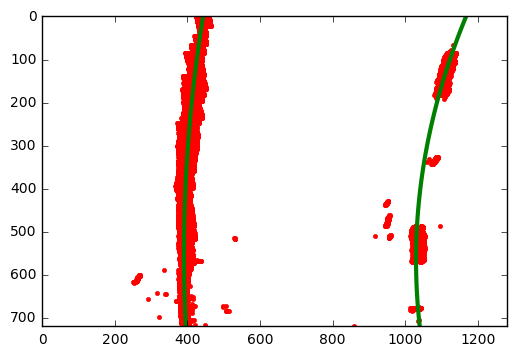

In [17]:
left=Line()
right=Line()

detected_l,n_buffered_left = left.update(left_binary)
detected_r,n_buffered_right = right.update(right_binary)

leftx = left.allx
left_fitx = left.current_fit_xvals
yvals_l = left.ally

rightx = right.allx
right_fitx = right.current_fit_xvals
yvals_r = right.ally

yvals = left.fit_yvals

plt.plot(rightx, yvals_r, '.', color='red')
plt.plot(right_fitx, yvals, color='green', linewidth=3)

plt.plot(leftx, yvals_l, '.', color='red')
plt.plot(left_fitx, yvals, color='green', linewidth=3)

plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.gca().invert_yaxis()
plt.savefig(out_dir+'fitted_lines.jpg')
plt.show()


In [18]:
def project_lane_lines(img,left_fitx,right_fitx,yvals):
    
    # Create an empty image to draw the lines
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    undist = undistort(img)    
    unwarped_img,Minv = unwarp(img)
    

    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

# 7. Warp the detected lane boundaries back onto the original image and output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [19]:
def process_image(img):
    global left
    global right
    undist = undistort(img)
    binary,_  = binarize_image(undist)
    warped,_  = warp(binary)
    warped_binary = region_of_interest(warped)
    
    window_center_l = 340
    if left.detected:
        window_center_l = left.line_pos        
    left_binary = get_binary_lane_image(warped_binary,left,window_center_l,width=300)
    
    window_center_r = 940
    if right.detected:
        window_center_r = right.line_pos        
    right_binary = get_binary_lane_image(warped_binary,right,window_center_r,width=300)
    
    detected_l,n_buffered_left = left.update(left_binary)
    detected_r,n_buffered_right = right.update(right_binary)    
    
    left_fitx = left.avgx
    right_fitx = right.avgx
    yvals = left.fit_yvals
    lane_width = 3.7
    off_center = -100*round(0.5*(right.line_base_pos-lane_width/2) +  0.5*(abs(left.line_base_pos)-lane_width/2),2)
    
    result = project_lane_lines(img,left_fitx,right_fitx,yvals)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    str1 = str('distance from center: '+str(off_center)+'cm')
    cv2.putText(result,str1,(430,630), font, 1,(0,0,255),2,cv2.LINE_AA)
    if left.radius_of_curvature and right.radius_of_curvature:
        curvature = 0.5*(round(right.radius_of_curvature/1000,1) + round(left.radius_of_curvature/1000,1))
        str2 = str('radius of curvature: '+str(curvature)+'km')
        cv2.putText(result,str2,(430,670), font, 1,(0,0,255),2,cv2.LINE_AA)    
    
    return result

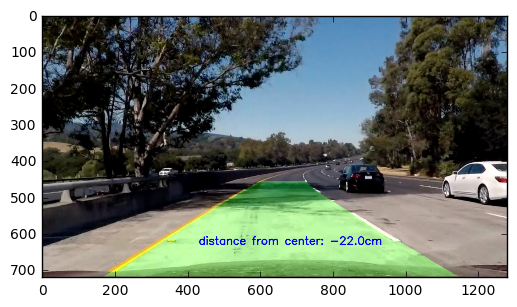

In [20]:
img = plt.imread('test_images/test5.jpg')
left = Line(7)
right = Line(7)

result = process_image(img)


plt.figure()
plt.imshow(result)
plt.show()
plt.imsave(out_dir+'project_test5.jpg',result)

# 8. Video Processing Pipeline
We use for pipeline the same fucnctions as we use for image transformation. For convenience we collected all of them in one cell. 

In [21]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import scipy
from scipy import signal
from collections import deque
import imageio
#imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# load pickled distortion matrix
with open('camera_distortion_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]    

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def undistort(img):
    result = cv2.undistort(img, mtx, dist, None, mtx)
    return result

def binarize_image(img, s_thresh=(120, 255), sx_thresh=(20, 255),l_thresh=(40,255)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    # sobelx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255))
    # l_channel_col=np.dstack((l_channel,l_channel, l_channel))
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    channels = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')        
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return  binary,channels

def warp(img):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    
    M = cv2.getPerspectiveTransform(src, dst)

    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M

def unwarp(img):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    M = cv2.getPerspectiveTransform(dst,src)
    unwarped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return unwarped, M

def find_peaks(img,thresh):
    img_half=img[int(img.shape[0]/2):,:,0]
    data = np.sum(img_half, axis=0)
    filtered = scipy.ndimage.filters.gaussian_filter1d(data,20)
    xs = np.arange(len(filtered))
    peak_ind = signal.find_peaks_cwt(filtered, np.arange(20,300))
    peaks = np.array(peak_ind)
    peaks = peaks[filtered[peak_ind]>thresh]
    return peaks,filtered


def get_next_slice(img,center_point,width):

    
    ny,nx,_ = img.shape
    mask  = np.zeros_like(img)
    if (center_point <= width/2): center_point = width/2
    if (center_point >= nx-width/2): center_point = nx-width/2
    
    left  = center_point - width/2
    right = center_point + width/2
    
    vertices = np.array([[(left,0),(left,ny), (right,ny),(right,0)]], dtype=np.int32)
    ignore_mask_color=(255,255,255)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked = cv2.bitwise_and(mask,img)

    hist = np.sum(masked[:,:,0],axis=0)
    if max(hist>10000):
        center = np.argmax(hist)
    else:
        center = center_point
        
    return masked,center

def lane_from_window(binary,center_point,width):
    n_zones=6
    ny,nx,nc = binary.shape
    zones = binary.reshape(n_zones,-1,nx,nc)
    zones = zones[::-1] # start from the bottom slice
    window,center = get_next_slice(zones[0],center_point,width)
    
    for zone in zones[1:]:
        next_window,center = get_next_slice(zone,center,width)
        window = np.vstack((next_window,window))
    
    return window


# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self,n=5):
        # length of queue to store data
        self.n = n
        #number of fits in buffer
        self.n_buffered = 0
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([],maxlen=n)
        #average x values of the fitted line over the last n iterations
        self.avgx = None
        # fit coeffs of the last n fits
        self.recent_fit_coeffs = deque([],maxlen=n)        
        #polynomial coefficients averaged over the last n iterations
        self.avg_fit_coeffs = None  
        # xvals of the most recent fit
        self.current_fit_xvals = [np.array([False])]  
        #polynomial coefficients for the most recent fit
        self.current_fit_coeffs = [np.array([False])]          
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #y values for line fit
        self.fit_yvals = np.linspace(0, 100, num=101)*7.2  # always the same y-range as image
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # origin (pixels) of fitted line at the bottom of the image
        self.line_pos = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 

    def set_current_fit_xvals(self):
        yvals = self.fit_yvals
        self.current_fit_xvals = self.current_fit_coeffs[0]*yvals**2 + self.current_fit_coeffs[1]*yvals + self.current_fit_coeffs[2]
        
    def add_data(self):
        self.recent_xfitted.appendleft(self.current_fit_xvals)
        self.recent_fit_coeffs.appendleft(self.current_fit_coeffs)
        assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
        self.n_buffered = len(self.recent_xfitted)
        
    def pop_data(self):        
        if self.n_buffered>0:
            self.recent_xfitted.pop()
            self.recent_fit_coeffs.pop()
            assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
            self.n_buffered = len(self.recent_xfitted)
        
        return self.n_buffered
        
    def set_avgx(self):
        fits = self.recent_xfitted
        if len(fits)>0:
            avg=0
            for fit in fits:
                avg +=np.array(fit)
            avg = avg / len(fits)
            self.avgx = avg
            
    def set_avgcoeffs(self):
        coeffs = self.recent_fit_coeffs
        if len(coeffs)>0:
            avg=0
            for coeff in coeffs:
                avg +=np.array(coeff)
            avg = avg / len(coeffs)
            self.avg_fit_coeffs = avg
    
    def set_allxy(self,lane_candidate):
        self.ally,self.allx = (lane_candidate[:,:,0]>254).nonzero()

    def set_current_fit_coeffs(self):
        self.current_fit_coeffs = np.polyfit(self.ally, self.allx, 2)
    
    def get_diffs(self):
        if self.n_buffered>0:
            self.diffs = self.current_fit_coeffs - self.avg_fit_coeffs
        else:
            self.diffs = np.array([0,0,0], dtype='float')                 
            
    def set_radius_of_curvature(self):
        # Define y-value where we want radius of curvature (choose bottom of the image)
        y_eval = max(self.fit_yvals)
        if self.avg_fit_coeffs is not None:
            self.radius_of_curvature = ((1 + (2*self.avg_fit_coeffs[0]*y_eval + self.avg_fit_coeffs[1])**2)**1.5) \
                             /np.absolute(2*self.avg_fit_coeffs[0])
                        
            
    def set_line_base_pos(self):
        y_eval = max(self.fit_yvals)
        self.line_pos = self.current_fit_coeffs[0]*y_eval**2 \
                        +self.current_fit_coeffs[1]*y_eval \
                        + self.current_fit_coeffs[2]
        basepos = 640
        
        self.line_base_pos = (self.line_pos - basepos)*3.7/600.0 # 3.7 meters is about 600 pixels in the x direction

    # here come sanity checks of the computed metrics
    def accept_lane(self):
        flag = True
        maxdist = 2.8  # distance in meters from the lane
        if(abs(self.line_base_pos) > maxdist ):
        #    print('lane is too far')
            flag  = False        
        if(self.n_buffered > 0):
            relative_delta = self.diffs / self.avg_fit_coeffs
            # allow maximally this percentage of variation in the fit coefficients from frame to frame
            if not (abs(relative_delta)<np.array([0.7,0.5,0.15])).all():
                #print('Fit coefficients are too far [%]',relative_delta)
                flag=False
                
        return flag
    
    def update(self,lane):
        self.set_allxy(lane)
        self.set_current_fit_coeffs()
        self.set_current_fit_xvals()
        self.set_radius_of_curvature()
        self.set_line_base_pos()
        self.get_diffs()
        if self.accept_lane():
            self.detected=True
            self.add_data()
            self.set_avgx()
            self.set_avgcoeffs()            
        else:
            self.detected=False            
            self.pop_data()
            if self.n_buffered>0:
                self.set_avgx()
                self.set_avgcoeffs()
                    
        return self.detected,self.n_buffered
    
def get_binary_lane_image(img,line,window_center,width=300):
    if line.detected:
        window_center=line.line_pos
    else:
        peaks,filtered = find_peaks(img,thresh=3000)
        #if len(peaks)!=2:
            #print('Difficult '+ str(len(peaks)) +' lanes detected!')
            #plt.imsave('difficult_image.jpg',img)                        

        peak_ind = np.argmin(abs(peaks-window_center))
        peak  = peaks[peak_ind]
        window_center = peak
    
    lane_binary = lane_from_window(img,window_center,width)
    return lane_binary 


def project_lane_lines(img,left_fitx,right_fitx,yvals):
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    undist = undistort(img)    
    unwarped_img,Minv = unwarp(img)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def process_image(img):
    global left
    global right
    undist = undistort(img)
    binary,_  = binarize_image(undist)
    warped,_  = warp(binary)
    warped_binary = region_of_interest(warped)
    str1 = ''
    str2 = ''
    
    window_center_l = 340
    if left.detected:
        window_center_l = left.line_pos        
    left_binary = get_binary_lane_image(warped_binary,left,window_center_l,width=300)
    
    window_center_r = 940
    if right.detected:
        window_center_r = right.line_pos        
    right_binary = get_binary_lane_image(warped_binary,right,window_center_r,width=300)
    
    detected_l,n_buffered_left = left.update(left_binary)
    detected_r,n_buffered_right = right.update(right_binary)    
    
    left_fitx = left.avgx
    right_fitx = right.avgx
    yvals = left.fit_yvals
    lane_width = 3.7
    off_center = -100*round(0.5*(right.line_base_pos-lane_width/2) +  0.5*(abs(left.line_base_pos)-lane_width/2),2)
    
    result = project_lane_lines(img,left_fitx,right_fitx,yvals)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    str1 = str('distance from center: '+str(off_center)+'cm')
    cv2.putText(result,str1,(430,630), font, 1,(0,0,255),2,cv2.LINE_AA)
    if left.radius_of_curvature and right.radius_of_curvature:
        curvature = 0.5*(round(right.radius_of_curvature/1000,1) + round(left.radius_of_curvature/1000,1))
        str2 = str('radius of curvature: '+str(curvature)+'km')
        cv2.putText(result,str2,(430,670), font, 1,(0,0,255),2,cv2.LINE_AA)    
    
    diagnosis = 0
    if diagnosis == 1:
        font = cv2.FONT_HERSHEY_COMPLEX
        middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
        #cv2.putText(middlepanel, str_curv, (30, 60), font, 1, (255,0,0), 2)
        cv2.putText(middlepanel, str1, (30, 60), font, 1, (255,0,0), 2)
        #cv2.putText(middlepanel, str_offset, (30, 90), font, 1, (255,0,0), 2)
        cv2.putText(middlepanel, str2, (30, 90), font, 1, (255,0,0), 2)
        # assemble the screen example
        diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
        diagScreen[0:720, 0:1280] = result
        #diagScreen[0:240, 1280:1600] = cv2.resize(warped, (320,240), interpolation=cv2.INTER_AREA) 
        #diagScreen[0:240, 1600:1920] = cv2.resize(stack_arr(mask_lane), (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[240:480, 1280:1600] = cv2.resize(apply_color_mask(image_HSV,warped,yellow_hsv_low,yellow_hsv_high), (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[240:480, 1600:1920] = cv2.resize(apply_color_mask(image_HSV,warped,white_hsv_low,white_hsv_high), (320,240), interpolation=cv2.INTER_AREA)*4
        #diagScreen[600:1080, 1280:1920] = cv2.resize(color_warp, (640,480), interpolation=cv2.INTER_AREA)*4
        #diagScreen[720:840, 0:1280] = middlepanel
        #diagScreen[840:1080, 0:320] = cv2.resize(newwarp, (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 320:640] = cv2.resize(stack_arr(255*mask_poly_L), (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 640:960] = cv2.resize(stack_arr(255*mask_poly_R), (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 960:1280] = cv2.resize(stack_arr(255*image_cmb1), (320,240), interpolation=cv2.INTER_AREA)
    
        #diagScreen[840:1080, 320:640] = cv2.resize(stack_arr(255*image_cmb1), (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 640:960] = cv2.resize(stack_arr(255*mask_poly_L+255*mask_poly_R), (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 960:1280] = cv2.resize(stack_arr(255*cv2.bitwise_and(image_cmb1,image_cmb1,
        #                                                                      mask=mask_poly_L+mask_poly_R)),
        #                                        (320,240), interpolation=cv2.INTER_AREA)
        return diagScreen
    else:
        return result
    

Check pipeline for sample image

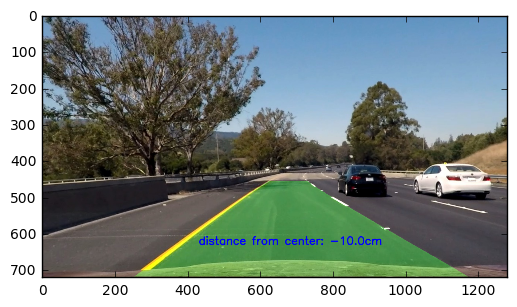

In [22]:
left = Line(7)
right = Line(7)
img = plt.imread('test_images/test6.jpg')

result = process_image(img)

plt.figure()
plt.imshow(result)
plt.show()

In [23]:
left = Line(7)
right = Line(7)

#from moviepy.editor import ImageClip

from moviepy.editor import VideoFileClip

from IPython.display import HTML

out_dir='./'
output = out_dir+'processed_project_video.mp4'
clip = VideoFileClip("project_video.mp4")

out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:14<00:00,  2.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 

Wall time: 6min 15s


# Conclusions and Future Directions

Final video output (youtube) https://youtu.be/9qA_sxot63E

The pipeline works not very well different road conditions especially with shadowed frames and I would like to improve my computer vision pipeline to detect lanes more exactly. 

I am going to tune up the parameters and use other color detection schemes. To do this I'd like to implement diagnosis panel created by Arnaldo Gunzi (reference https://chatbotslife.com/advanced-lane-line-project-7635ddca1960#.o0bdspyn4)